# 국민청원 데이터로 청원 카테고리 분류하기
* 청와대 국민청원 : https://www1.president.go.kr/petitions

> 학습세트의 카테고리를 바탕으로 테스트 세트의 청원 카테고리를 분류해 봅니다.

1. 학습세트와 테스트세트를 7:3으로 임의로 나누기
1. 데이터 전처리
1. 단어 벡터화(BOW, TF-IDF)
1. 분류기 설정하기(Random Forest)
1. 분류기로 학습시키기
1. 학습의 정확도 보기
1. 테스트 데이터 예측하기
1. 실제 데이터와 예측결과의 차이를 보기

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(377756, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [4]:
# 전체 데이터 중 투표가 100건 이상인 데이터를 기준으로 가져옵니다.
df = petitions.loc[(petitions['votes'] > 100)].copy()
df.shape

(17709, 8)

In [5]:
df.describe()

,article_id,answered,votes
count,17709.000000,17709.000000,1.770900e+04
mean,263551.931278,0.001638,3.008568e+03
std,130538.656063,0.040435,2.217389e+04
min,28.000000,0.000000,1.010000e+02
25%,168398.000000,0.000000,1.440000e+02
50%,258392.000000,0.000000,2.400000e+02
75%,382174.000000,0.000000,6.440000e+02
max,492036.000000,1.000000,1.192049e+06


In [6]:
category_count = df['category'].value_counts()
category_count

정치개혁           2452
인권/성평등         2217
육아/교육          1772
기타             1730
안전/환경          1553
보건복지           1336
교통/건축/국토       1313
문화/예술/체육/언론    1041
외교/통일/국방        880
행정              847
경제민주화           745
일자리             654
반려동물            395
미래              389
저출산/고령화대책       178
성장동력            132
농산어촌             75
Name: category, dtype: int64

In [7]:
len(df['category'].unique())

17

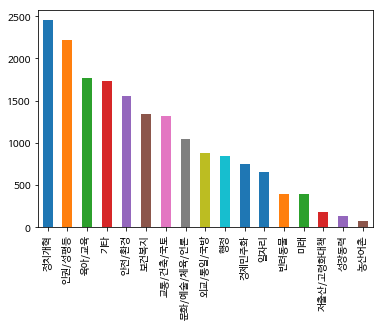

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt

# 나눔 바른고딕이 설치되어 있어야 합니다.
# 해당 폰트가 없다면 설치된 폰트명으로 지정해 주어야 합니다.
plt.rcParams["font.family"] = 'NanumBarunGothic'
category_count.plot(kind='bar')

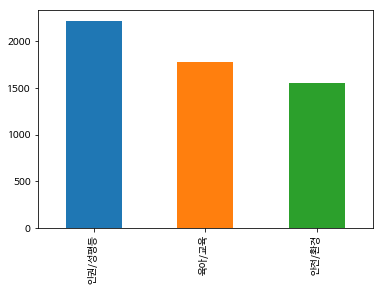

In [9]:
df = df[(df['category'] == '인권/성평등') | (df['category'] == '육아/교육') | (df['category'] == '안전/환경')]
category_count = df['category'].value_counts()
category_count
category_count.plot(kind='bar')

In [10]:
# 예측값과 실제값 비교를 위해 컬럼을 하나 더 생성합니다.
df['category_pred'] = df['category'].copy()

In [11]:
df.head()

,article_id,start,end,answered,votes,category,title,content,category_pred
20,42,2017-08-19,2017-09-18,0,173,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육
42,65,2017-08-20,2017-11-18,0,285,육아/교육,기간제교사 정규직 및 무기계약직전환 반대합니다,"저는 영어전문강사, 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합...",육아/교육
43,66,2017-08-20,2017-09-19,0,263,육아/교육,기간제 교사 및 각종 강사들의 무기계약 및 정규직 전환 반대합니다!,"정부에서 제시한 일자리 로드맵에서 사회적 합의를 위해 청년들에게 인기가 많고, 공채...",육아/교육


In [12]:
# 첫 번째 인덱스를 가져와 봅니다.
sample_index = df.iloc[0][0]
sample_index

42

In [13]:
sample_title = df['title'][sample_index]
sample_title

'기간제교사 정규직 및 무기계약직전환 반대합니다'

In [14]:
sample_content = petitions['content'][sample_index]
sample_content

'저는 영어전문강사, 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합니다.\\n임용고사라는 정당한 시험으로 정교사가 될 수 있는 길이 있습니다.  기간제교사를 뽑는 절차 또한 투명한 것 또한 명확한 것은 아니며, 참교사를 꿈꾸며 교대와 사범대를 재학중인, 임용고사 시험을 준비하는 학생들의 꿈과 희망을 짓밟지 말아주세요.\\n학교는 교육의 장으로 교육엔 학생, 교사, 교과서 이 세개가 중심이 되어야 하는 곳입니다. 그런 학교를 교육의 장이 아닌 일자리 창출의 장으로 보지 말아주세요.\\n대통령님, 현 정부 모두 학생들과 학부모, 대중의 여론의 대다수의 목소리를 들어주세요.\\n소통의 정부 약속을 지켜주세요 ㅠㅠ\\n열심히 공부해서 꿈을 향해 정정당당한 절차로 정교사가 되고자 하는 사람들의 목소리를 정의를 바라봐주세요! ㅠㅠ\\n또한, 영어전문강사, 스포츠전문강사를 무기계약직으로 전환해주지 않는 건, 2014년 헌법재판소에서도 합법적이라고 판결을 내렸습니다. (헌법재판소 사건번호 2012헌마380) 그렇기 때문에 4년 이상을 근무했건 8년을 근무했건, 무기계약직으로 전환해주지 않는 건 위헌이라 할 수 없습니다. 대전시 고등법원의 판단보다는 헌법재판소의 판단이 더 중요하지 않을까요?\\n아래 헌법재판소의 판결문을 참고해주세요.\\n‘구 초·중등교육법 제22조 제2항, 같은 법 시행령 제42조 제5항에 의하면, 영어회화 전문강사는 기간을 정하여 임용할 때 그 기간은 1년 이내로 하되, 필요한 경우 계속 근무한 기간이 4년을 초과하지 아니하는 범위에서 그 기간을 연장할 수 있다고 규정하고 있으므로, 기간제 및 단시간 근로자의 보호 등에 관한 법률 제4조 제1항 단서 제6호, 같은 법 시행령 제3조 제3항 제1호에 해당하여 무기계약직 근로자 간주 대상에서 제외된다 할 것이다.\\n사정이 이와 같다면, 영어회화 전문강사의 경우 기간제근로자이지만 그 사용기간이 2년을 초과하더라도 무기계약직 근로자로 간주하지 아니하는 것은 위 관계법령의 규정에 의하여 이미 확

# 전처리 하기 
* 특수문자 제거
* 개행문자 제거
* 불용어 처리

In [15]:
def preprocessing(text):
    # 개행문자 제거
    text= str(text)
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    return text

In [16]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

## 샘플데이터에 먼저 적용해 보기

In [17]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [18]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [19]:
pre_sample_content

'영어전문강사  스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합니다  임용고사라는 정당한 시험으로 정교사가 될 길이   기간제교사를 뽑는 절차 또한 투명한 것 또한 명확한 아니며  참교사를 꿈꾸며 교대와 사범대를 재학중인  임용고사 시험을 준비하는 학생들의 꿈과 희망을 짓밟지 말아주세요  학교는 교육의 장으로 교육엔 학생  교사  교과서 이 세개가 중심이 되어야 곳입니다  그런 학교를 교육의 장이 아닌 일자리 창출의 장으로 보지 말아주세요  대통령님  정부 모두 학생들과 학부모  대중의 여론의 대다수의 목소리를 들어주세요  소통의 정부 약속을 지켜주세요 ㅠㅠ 열심히 공부해서 꿈을 향해 정정당당한 절차로 정교사가 되고자 사람들의 목소리를 정의를 바라봐주세요  ㅠㅠ 또한  영어전문강사  스포츠전문강사를 무기계약직으로 전환해주지 않는 건      년 헌법재판소에서도 합법적이라고 판결을 내렸습니다   헌법재판소 사건번호     헌마     그렇기 때문에  년 이상을 근무했건  년을 근무했건  무기계약직으로 전환해주지 않는 건 위헌이라  대전시 고등법원의 판단보다는 헌법재판소의 판단이 중요하지 않을까요  아래 헌법재판소의 판결문을 참고해주세요   구 초 중등교육법  조 항  법 시행령  조 항에 의하면  영어회화 전문강사는 기간을 정하여 임용할 때 기간은  년 이내로 하되  필요한 경우 계속 근무한 기간이  년을 초과하지 아니하는 범위에서 기간을 연장할 있다고 규정하고 있으므로  기간제 단시간 근로자의 보호 등에 관한 법률 조 항 단서 호  법 시행령 조 항 호에 해당하여 무기계약직 근로자 간주 대상에서 제외된다 것이다  사정이 이와 같다면  영어회화 전문강사의 경우 기간제근로자이지만 사용기간이  년을 초과하더라도 무기계약직 근로자로 간주하지 아니하는 위 관계법령의 규정에 의하여 이미 확정된 내용이므로  이 사건 지침조항은 위 관계법령의 규정에 의하여 확정된 내용을 확인한 것에 불과하여 청구인들의 법적 지위에 어떠한 영향을 미친다고 볼 없다  따라서 이

## 전체 데이터에 적용하기

In [20]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 670 ms, sys: 22.9 ms, total: 693 ms
Wall time: 992 ms


In [21]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 964 ms, sys: 19.2 ms, total: 983 ms
Wall time: 1.05 s


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [22]:
df = df.reindex()

In [23]:
df.shape

(5542, 11)

In [24]:
split_count = int(df.shape[0] * 0.7)
split_count

3879

In [25]:
df_train = df[:split_count].copy()
df_train.shape

(3879, 11)

In [26]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
20,42,2017-08-19,2017-09-18,0,173,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
21,43,2017-08-19,2017-09-18,0,11293,육아/교육,기간제 교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
24,46,2017-08-19,2017-09-18,0,1933,육아/교육,기간제교사의 정규직화를 반대합니다.,"대통령님, 안녕하세요. 저는 임용을 준비하고 수험생입니다. 처음 기간제 정규직화 된...",육아/교육,대통령님 안녕하세요 저는 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된...,대통령님 안녕하세요 임용을 준비하고 수험생입니다 처음 기간제 정규직화 된다고 ...
42,65,2017-08-20,2017-11-18,0,285,육아/교육,기간제교사 정규직 및 무기계약직전환 반대합니다,"저는 영어전문강사, 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합...",육아/교육,저는 영어전문강사 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합...,영어전문강사 스포츠전문강사를 무기계약직 혹은 정규직으로 전환하는 것에 반대합니다 ...
43,66,2017-08-20,2017-09-19,0,263,육아/교육,기간제 교사 및 각종 강사들의 무기계약 및 정규직 전환 반대합니다!,"정부에서 제시한 일자리 로드맵에서 사회적 합의를 위해 청년들에게 인기가 많고, 공채...",육아/교육,정부에서 제시한 일자리 로드맵에서 사회적 합의를 위해 청년들에게 인기가 많고 공채...,정부에서 제시한 일자리 로드맵에서 사회적 합의를 청년들에게 인기가 많고 공채가 부...


In [27]:
df_test = df[split_count:].copy()
df_test.shape

(1663, 11)

In [28]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,category_pred,content_preprocessing,content_preprocessing2
280034,363606,2018-09-02,2018-10-02,0,109,안전/환경,쓰레기 무단투기에 강력한 처벌을 해주세요,안녕하세요 저는 늘푸른중학교 3학년에 재학중인 학생입니다.사회시간 사회 문제점에 대...,안전/환경,안녕하세요 저는 늘푸른중학교 학년에 재학중인 학생입니다 사회시간 사회 문제점에 대...,안녕하세요 늘푸른중학교 학년에 재학중인 학생입니다 사회시간 사회 문제점에 대해 찾...
280119,363714,2018-09-03,2018-10-03,0,978,안전/환경,광양 바이오매스 화력발전소 건설을 철회해 주세요!!! 광양 순천 여수 사람들 죽...,친애하는 문재인 대통령님\n전남 동부권 지역 주민 50만 대부분 인구가 살아가는 집...,안전/환경,친애하는 문재인 대통령님 전남 동부권 지역 주민 만 대부분 인구가 살아가는 집단...,친애하는 문재인 대통령님 전남 동부권 지역 주민 만 대부분 인구가 살아가는 집단...
280231,363882,2018-09-03,2018-10-03,0,187,육아/교육,유은혜 장관 지명철회 요청,유은혜 부총리겸 교육부장관 지명 철회\n비 전문가가 나라 교육 망칠일 있습니까?\n...,육아/교육,유은혜 부총리겸 교육부장관 지명 철회 비 전문가가 나라 교육 망칠일 있습니까 철회...,유은혜 부총리겸 교육부장관 지명 철회 비 전문가가 나라 교육 망칠일 있습니까 철회...
280422,364118,2018-09-03,2018-10-03,0,151,육아/교육,유은혜 의원 장관임명 철회요청,유은혜 의원은 교육부 장관으로서 적임자가 아닙니다.\n세가지 이유에서 입니다.\n첫...,육아/교육,유은혜 의원은 교육부 장관으로서 적임자가 아닙니다 세가지 이유에서 입니다 첫째 ...,유은혜 의원은 교육부 장관으로서 적임자가 아닙니다 세가지 이유에서 첫째 교육 ...
280471,364188,2018-09-03,2018-10-03,0,131,육아/교육,유은혜 지명철회..... 문정부는 국민들과 소통을 안하는가???,국민들이 반대하고.. 피감기관에 사무실을 입주해 있는자를 임명하려 한다.\n박근혜정...,육아/교육,국민들이 반대하고 피감기관에 사무실을 입주해 있는자를 임명하려 한다 박근혜정부...,국민들이 반대하고 피감기관에 사무실을 입주해 있는자를 임명하려 박근혜정부에서 ...


# 카테고리
## 학습 세트의 카테고리 보기

In [29]:
df_train_category_value = pd.DataFrame(df_train['category'].value_counts())
df_train_category_percent = pd.DataFrame(df_train['category'].value_counts(normalize=True))
df_train_category= df_train_category_value.merge(df_train_category_percent, left_index=True, right_index=True)
df_train_category.columns = ['청원수', '청원비율']
df_train_category

,청원수,청원비율
인권/성평등,1598,0.411962
육아/교육,1177,0.303429
안전/환경,1104,0.284609


In [30]:
df_test_category_value = pd.DataFrame(df_test['category'].value_counts())
df_test_category_percent = pd.DataFrame(df_test['category'].value_counts(normalize=True))
df_test_category = df_test_category_value.merge(df_test_category_percent, left_index=True, right_index=True)
df_test_category.columns = ['청원수', '청원비율']
df_test_category

,청원수,청원비율
인권/성평등,619,0.372219
육아/교육,595,0.357787
안전/환경,449,0.269994


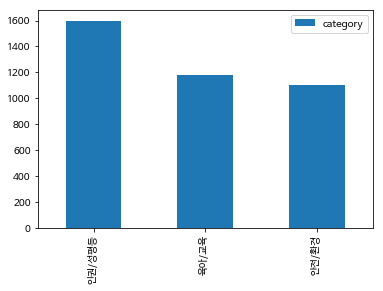

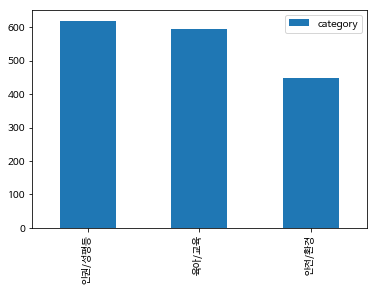

In [31]:
df_train_category_value.plot(kind='bar')
df_test_category_value.plot(kind='bar')

# 단어 벡터화 하기

## BOW(Bag of Words)

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

stops = ['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = stops, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None,
        stop_words=['and', 'article', 'html', '수', '현', '있는', '있습니다', '그', '년도', '합니다', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜', '같은', '같습니다', '없습니다', '위해', '한다'],
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 10.4 s, sys: 626 ms, total: 11 s
Wall time: 11.6 s


In [34]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 5.07 s, sys: 253 ms, total: 5.32 s
Wall time: 5.57 s


In [35]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'articleview',
 'articleview idxno',
 'a는',
 'a씨는',
 'cctv',
 'cctv를',
 'co',
 'co kr',
 'co kr news']

In [36]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,articleview,articleview idxno,a는,a씨는,cctv,cctv를,co,co kr,co kr news,...,회장의,후에,훨씬,힘든,힘들게,힘들고,힘듭니다,힘없는,힘을,힘이
0,140,61,61,110,90,203,197,76,435,119,...,119,84,57,197,121,49,58,55,110,84


## TF-IDF 로 가중치 적용하기

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 18.9 ms, sys: 3.83 ms, total: 22.8 ms
Wall time: 25.2 ms


In [39]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 10.5 ms, sys: 2.46 ms, total: 12.9 ms
Wall time: 12 ms


In [40]:
test_feature_tfidf.shape

(1663, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [ ]:
# 학습에 사용할 y_label 을 넣어줍니다.
# 어떤 분야의 청원인지 예측할 것이기 때문에 category를 넣어줍니다.
y_label = df_train['category']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 5.1 s, sys: 70.5 ms, total: 5.17 s
Wall time: 1.71 s


# 학습이 잘 되었는지 평가하기

시험공부에 비유해 보면,
1. 기출문제를 모은다
2. 공부한다
3. 시험본다

여기에서 2번 단계를 하는 여러 전략이 있을텐데요, 기출문제를 모두 외워버리면 과연 내가 실제 시험을 잘 치룰 수 있을지 아니면 공부를 더 해야할지 판단하기가 애매합니다. 괜찮은 전략 중 하나는 기출문제 중 일부를 임의로 뽑아내서 공부하고(training set을 이용한 학습), 나머지 기출문제를 풀어보며 내가 얼마나 잘 푸는지 평가를 해보는겁니다(validation set을 통해 학습의 성과를 검증). 잘 된다 싶으면 시험을 볼 준비가 된 것입니다(실전 투입).


기출문제를 몽땅 외우면 기출문제 내에서는 100점을 받겠지만(overfitting), 실전에서도 그러한 성적을 가두리라 기대하기 어렵습니다.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
%time score = cross_val_score(forest, train_feature_vector, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

## Mean Absolute Error

In [ ]:
round(np.mean(score)*100,2)

# 예측

In [ ]:
# 테스트 데이터를 넣고 예측합니다.
y_pred = forest.predict(test_feature_vector)
y_pred[:3]

In [ ]:
y_pred.shape

In [ ]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 줍니다.
output = pd.DataFrame(data={'category_pred':y_pred})
output.head()

In [ ]:
# 0과 1이 어떻게 집계 되었는지 확인합니다.
output['category_pred'].value_counts()

In [ ]:
df_test['category_pred'] = y_pred

## 예측결과 미리보기

In [ ]:
df_test['pred_diff'] = 0
df_test['pred_diff'] = (df_test['category'] == df_test['category_pred'] ) == 1
df_test['pred_diff'] = df_test['pred_diff'].astype(int)
df_test.head()

In [ ]:
# 맞게 예측한 청원은 1, 틀린 예측은 0으로 표기되었습니다.
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

In [ ]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[1]))

In [ ]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('예측 비율 {}'.format(acc))

In [ ]:
# 제대로 예측한 카테고리 데이터를 봅니다.
predict_correct = df_test.loc[df_test['pred_diff'] == 1]
predict_correct.head()

## 잘못 예측한 카테고리 보기

In [ ]:
predict_incorrect = df_test.loc[df_test['pred_diff'] == 0].copy()
predict_incorrect.head()

In [ ]:
predict_incorrect_value = predict_incorrect['category'].value_counts()
predict_incorrect_value

In [ ]:
# 잘못 예측한 카테고리 중 인권/성평등 카테고리가 가장 많습니다.
predict_incorrect_value.plot(kind='bar')

# 왜 예측의 정확도가 낮을까요?
* 청원을 입력하는 사람마다 카테고리 분류 기준이 정확하지 않은 것 같습니다.
* 기타로 예측한 분류도 특정 카테고리로 분류해도 될 것으로 보여집니다.

In [ ]:
predict_incorrect[['category', 'category_pred', 'title', 'content']].head(10)

## 원래 데이터 중 기타로 분류되었으나 분류기가 다르게 예측한 청원을 봅니다.

In [ ]:
predict_incorrect_etc = predict_incorrect.loc[predict_incorrect['category'] == '기타'].copy()
predict_incorrect_etc[['category', 'category_pred', 'title', 'content']].head(10)

## 아래의 예측비율을 높여보세요. 
* 학습 세트와 테스트 세트의 비율을 7:3으로 유지하도록 하고 다음의 방법들을 사용해 볼 수 있습니다. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * 벡터 기법에 들어가는 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경

In [ ]:
acc = ( pred_diff[1] / y_pred.shape[0] )*100 
print('정답 예측 비율 {}'.format(acc))